In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp

np.random.seed(123)

%matplotlib inline

Using gpu device 0: GeForce GT 650M (CNMeM is disabled, CuDNN not available)


In [1]:
%%bash
head data/moves_export/csv/full/summary.csv

Date,Activity,Group,Duration,Distance,Steps,Calories
2/7/15,walking,walking,2797,1.944,4121,0
2/7/15,transport,transport,5636,31.162,0,0
2/8/15,walking,walking,4170,2.440,5063,0
2/8/15,transport,transport,7121,54.483,0,0
2/9/15,walking,walking,3444,2.339,5149,0
2/9/15,cycling,cycling,1911,6.669,0,0
2/10/15,walking,walking,3032,2.046,4474,0
2/10/15,cycling,cycling,1850,5.315,0,0
2/10/15,transport,transport,1512,6.089,0,0


In [3]:
df = pd.read_csv('data/moves_export/csv/full/summary.csv')

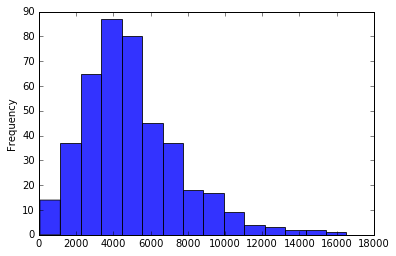

In [4]:
df = df[df['Activity'] == 'walking']
df['Steps'].plot.hist(alpha=0.8, bins=15)

# Model By Hand

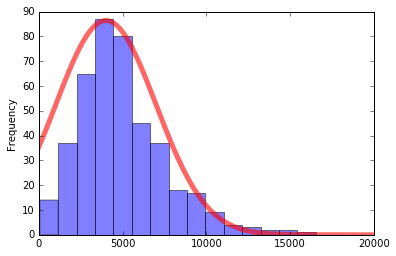

In [5]:
from scipy.stats import truncnorm
fig, ax = plt.subplots(1,1)
a, b = -3000, 20000
mu, var = 4000, 3000
x = np.linspace(0, 20000, 100)
ax.plot(x, truncnorm.pdf(x, a, b, mu, var)*10000 * 65,
        'r-', lw=5, alpha=0.6,
        label='truncnorm pdf')
df['Steps'].plot.hist(alpha=0.5, bins=15)

In [6]:
steps = df['Steps'].as_matrix().squeeze()
steps[:10]

array([4121, 5063, 5149, 4474, 6397, 6929, 7905, 4803, 3434, 4262])

# Model using Normal

Above is the histogram of steps I've taken per day in approximately the last year. I would like to use Bayesian estimation to find the mean and variance of this distribution.

$$ \mu_X \sim Norm(0, 10000) $$
$$ \sigma_X \sim Uniform(0, 5000) $$
$$ X \sim Norm(\mu_X, \sigma_X) $$

In [7]:
the_model = pm.Model()
with the_model:
    mu_X = pm.Normal('mu_X', mu=0, sd=10000)
    sd_X = pm.Uniform('sd_X', lower=0, upper=5000)
    X = pm.Normal('X', mu=mu_X, sd=sd_X, observed=steps)

Applied interval-transform to sd_X and added transformed sd_X_interval to model.


In [8]:
with the_model:
    # obtain starting values via MAP
    start = pm.find_MAP(fmin=sp.optimize.fmin_powell)
    print('start: ', start)
    
    # draw 500 burn-in samples
    trace = pm.sample(500, start=start)
    print('Done with burn-in.')
    
    # draw N posterior samples
    N = 30000
    trace = pm.sample(N, start=start)

start:  {'sd_X_interval': array(0.12130002150435873), 'mu_X': array(4969.88582855648)}
Assigned NUTS to mu_X
Assigned NUTS to sd_X_interval
 [-----------------100%-----------------] 500 of 500 complete in 0.4 secDone with burn-in.
Assigned NUTS to mu_X
Assigned NUTS to sd_X_interval
 [-----------------100%-----------------] 30000 of 30000 complete in 16.4 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1229906a0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121feaef0>]], dtype=object)

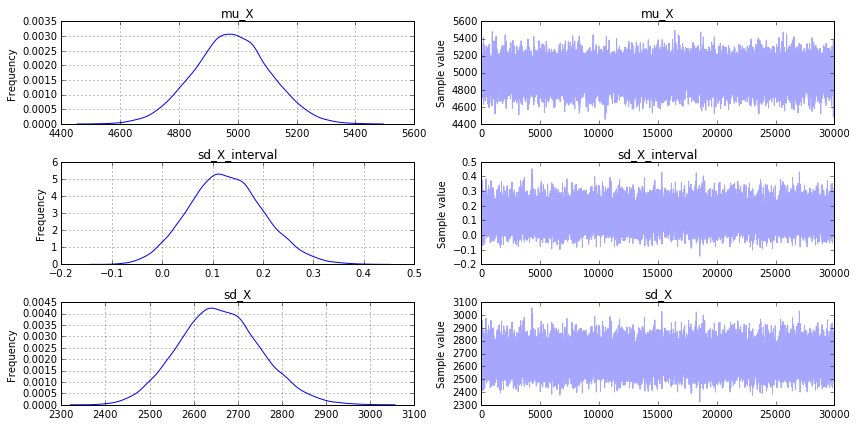

In [9]:
pm.traceplot(trace)

In [10]:
pm.summary(trace, alpha=0.05)


mu_X:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4979.094         130.204          0.743            [4723.692, 5233.002]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  4724.585       4892.615       4979.115       5064.848       5234.445


sd_X_interval:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.128            0.075            0.001            [-0.013, 0.278]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.010         0.077          0.126          0.177          0.282


sd_X:

  Mean             SD               MC Error         95% HPD interval
  ---------

/Users/mjdillon/anaconda/envs/pymc3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


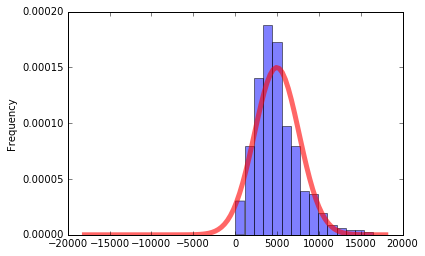

In [11]:
from scipy.stats import norm, gamma
fig, ax = plt.subplots(1,1)
mu, var = trace['mu_X'].mean(), trace['sd_X'].mean()
x = np.linspace(-18000, 18000, 100)
ax.plot(x, norm.pdf(x, mu, var), 'r-', lw=5, alpha=0.6, label='norm pdf')
df['Steps'].plot.hist(alpha=0.5, bins=15, normed=True)

# Model Using Gamma

In [12]:
the_model = pm.Model()
with the_model:
    alpha_X = pm.Uniform('alpha_X', lower=0, upper=10)
    beta_X = pm.Uniform('beta_X', lower=0, upper=10)
    X = pm.Gamma('X', alpha=alpha_X, beta=beta_X, observed=steps)

Applied interval-transform to alpha_X and added transformed alpha_X_interval to model.
Applied interval-transform to beta_X and added transformed beta_X_interval to model.


In [13]:
with the_model:
    # obtain starting values via MAP
    start = pm.find_MAP(fmin=sp.optimize.fmin_powell)
    print('start: ', start)
    
    # draw 500 burn-in samples
    trace = pm.sample(500, start=start)
    print('Done with burn-in.')
    
    # draw N posterior samples
    N = 30000
    trace = pm.sample(N, start=start)

start:  {'beta_X_interval': array(-9.771741301197796), 'alpha_X_interval': array(-0.8638589909736218)}
Assigned NUTS to alpha_X_interval
Assigned NUTS to beta_X_interval
 [-----------------100%-----------------] 500 of 500 complete in 0.8 secDone with burn-in.
Assigned NUTS to alpha_X_interval
Assigned NUTS to beta_X_interval
 [-----------------100%-----------------] 30000 of 30000 complete in 36.4 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b22e390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12c486e48>]], dtype=object)

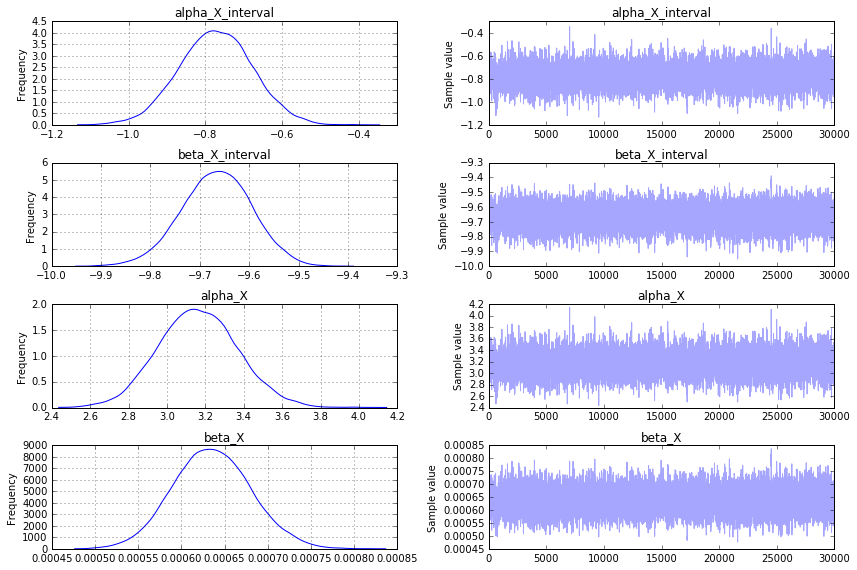

In [14]:
pm.traceplot(trace)

In [15]:
pm.summary(trace, alpha=0.05)


alpha_X_interval:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.772           0.096            0.001            [-0.956, -0.584]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.959         -0.837         -0.772         -0.708         -0.586


beta_X_interval:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -9.666           0.071            0.001            [-9.805, -9.527]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -9.809         -9.713         -9.664         -9.617         -9.530


alpha_X:

  Mean             SD               MC Error         95% HPD interva

/Users/mjdillon/anaconda/envs/pymc3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


alpha:  3.16334176716
beta:  0.000635669571055


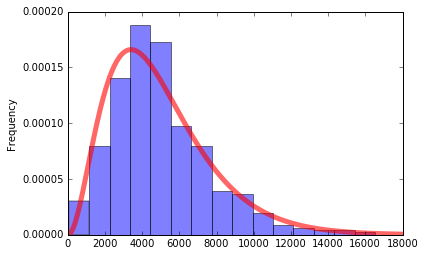

In [16]:
from scipy.stats import norm, gamma
fig, ax = plt.subplots(1,1)
alpha, beta = trace['alpha_X'].mean(), trace['beta_X'].mean()
print('alpha: ', alpha)
print('beta: ', beta)
x = np.linspace(start=0, stop=18000,num=1000)
ax.plot(x, gamma.pdf(x, alpha, scale=1./beta), 'r-', lw=5, alpha=0.6,
        label='gamma pdf')
df['Steps'].plot.hist(alpha=0.5, bins=15, normed=True)